<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/DataQuestTradingBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import

From this youtube video https://www.youtube.com/watch?v=1O_BenficgE&t=1308s

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


^GSPC is for s&p 500

In [2]:
sp500 = yf.Ticker("^GSPC").history(period='max')


In [3]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-11 00:00:00-05:00,6008.859863,6017.310059,5986.689941,6001.350098,4333000000,0.0,0.0
2024-11-12 00:00:00-05:00,6003.600098,6009.919922,5960.080078,5983.990234,4243400000,0.0,0.0
2024-11-13 00:00:00-05:00,5985.750000,6008.189941,5965.910156,5985.379883,4220180000,0.0,0.0


In [4]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2024-11-04 00:00:00-05:00', '2024-11-05 00:00:00-05:00',
               '2024-11-06 00:00:00-05:00', '2024-11-07 00:00:00-05:00',
               '2024-11-08 00:00:00-05:00', '2024-11-11 00:00:00-05:00',
               '2024-11-12 00:00:00-05:00', '2024-11-13 00:00:00-05:00',
               '2024-11-14 00:00:00-05:00', '2024-11-15 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24337, freq=None)

<Axes: xlabel='Date'>

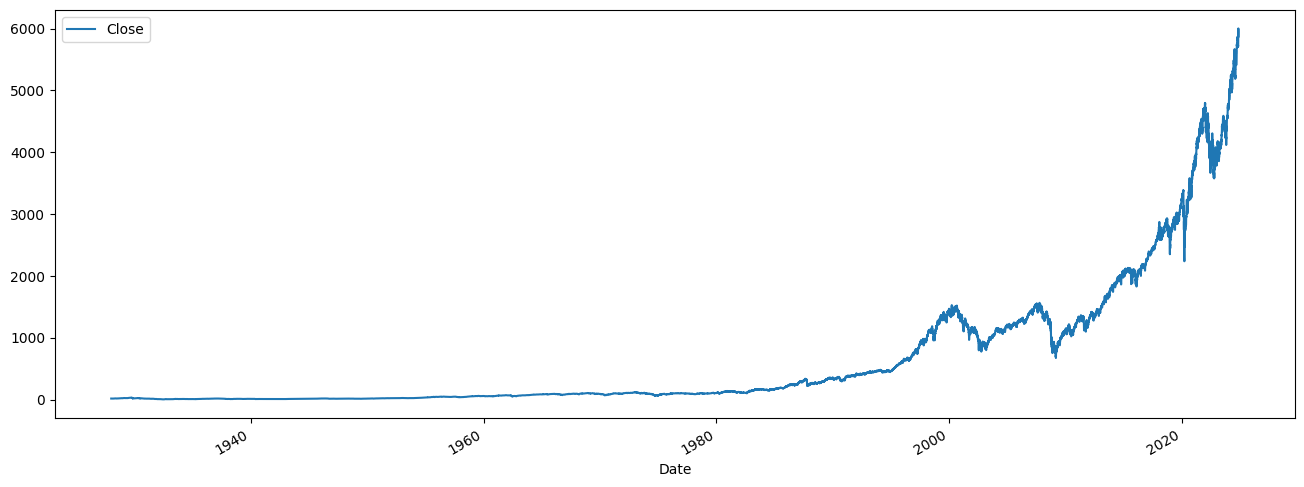

In [5]:
sp500.plot.line(y="Close", use_index=True, figsize=(16,6))

In [6]:
# Dividends and Stock splits are unnecesary for an etf
del sp500['Dividends']
del sp500['Stock Splits']

In [7]:
sp500["Tommorow"] = sp500["Close"].shift(-1)

In [8]:
sp500["Target"] = (sp500["Tommorow"] > sp500["Close"]).astype(int)

In [9]:
sp500 = sp500.loc["1990-01-01":].copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split=100, random_state=42)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [12]:
from sklearn.metrics import precision_score, confusion_matrix

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5714285714285714

<Axes: xlabel='Date'>

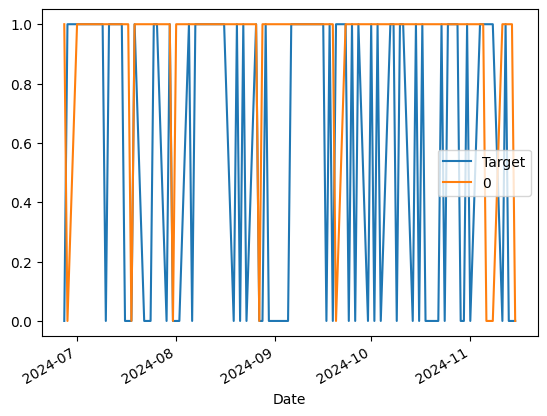

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name= "Predictions")
  combined = pd.concat([test["Target"],preds], axis = 1)
  return combined

In [15]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Verify "Target" exists in both train and test
        if "Target" not in train.columns or "Target" not in test.columns:
            raise KeyError("The 'Target' column is missing from train or test data.")

        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [16]:
predictions = backtest(sp500, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3539
1,2748


In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5305676855895196

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535709
0,0.464291


Adding Additional predictors to the model. Finding rolling averages with different time horizons

In [20]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

In [21]:
sp500

,Open,High,Low,Close,Volume,Tommorow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11 00:00:00-05:00,6008.859863,6017.310059,5986.689941,6001.350098,4333000000,5983.990234,0,1.000484,2.0,1.010948,5.0,1.050171,34.0,1.143238,148.0,1.349436,529.0
2024-11-12 00:00:00-05:00,6003.600098,6009.919922,5960.080078,5983.990234,4243400000,5985.379883,1,0.998552,1.0,1.001236,4.0,1.045987,33.0,1.138640,147.0,1.344806,528.0
2024-11-13 00:00:00-05:00,5985.750000,6008.189941,5965.910156,5985.379883,4220180000,5949.169922,0,1.000116,1.0,0.999584,4.0,1.045048,34.0,1.137620,147.0,1.344385,529.0


In [22]:
sp500 = sp500.dropna()

In [26]:
sp500

,Open,High,Low,Close,Volume,Tommorow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08 00:00:00-05:00,5976.759766,6012.450195,5976.759766,5995.540039,4666740000,6001.350098,1,1.001875,2.0,1.019888,4.0,1.050524,34.0,1.143516,147.0,1.348868,528.0
2024-11-11 00:00:00-05:00,6008.859863,6017.310059,5986.689941,6001.350098,4333000000,5983.990234,0,1.000484,2.0,1.010948,5.0,1.050171,34.0,1.143238,148.0,1.349436,529.0
2024-11-12 00:00:00-05:00,6003.600098,6009.919922,5960.080078,5983.990234,4243400000,5985.379883,1,0.998552,1.0,1.001236,4.0,1.045987,33.0,1.138640,147.0,1.344806,528.0


In [33]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [47]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .63] = 1
  preds[preds < .63] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [48]:
predictions = backtest(sp500, model, new_predictors)

In [49]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6056338028169014

In [43]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,4799
1.0,487
